# 지식 그래프를 활용한 RAG 추론 향상

_작성자: [Diego Carpintero](https://github.com/dcarpintero), 번역: [최성우](https://github.com/nuatmochoi)_

지식 그래프는 상호 연결된 정보를 사람과 기계 모두가 이해할 수 있는 형식으로 모델링하고 저장하는 방법을 제공합니다. 이러한 그래프는 엔티티와 그들의 관계를 나타내는 *노드*와 *엣지*로 구성됩니다. 전통적인 데이터베이스와 달리, 그래프의 본질적인 표현력은 더 풍부한 의미론적 이해를 가능하게 하며, 고정된 스키마에 제약받지 않고 새로운 엔티티 유형과 관계를 수용할 수 있는 유연성을 제공합니다.

지식 그래프를 임베딩(벡터 검색)과 결합함으로써, *다중 홉 연결성*과 *정보의 맥락적 이해*를 활용하여 LLM의 추론과 설명 가능성을 향상시킬 수 있습니다.

이 노트북은 이 접근 방식의 실제 구현을 탐구하며, 다음과 같은 방법을 보여줍니다.
- 합성 데이터셋을 사용하여 [Neo4j](https://neo4j.com/docs/)에서 연구 출판물 관련 지식 그래프 구축
- [임베딩 모델](https://python.langchain.com/v0.2/docs/integrations/text_embedding/)을 사용하여 데이터 필드의 일부를 고차원 벡터 공간으로 투영
- 유사도 검색을 가능하게 하는 임베딩에 대한 벡터 인덱스 구축
- [LangChain](https://python.langchain.com/v0.2/docs/introduction/)을 사용하여 사용자 쿼리를 [cypher](https://neo4j.com/docs/cypher-manual/current/introduction/) 문으로 쉽게 변환하여 자연어로 그래프에서 인사이트 추출

<p align="center">
  <img src="https://raw.githubusercontent.com/dcarpintero/generative-ai-101/main/static/knowledge-graphs.png">
</p>

## 초기화

In [ ]:
%pip install neo4j langchain langchain_openai langchain-community python-dotenv --quiet

### Neo4j 인스턴스 설정

그래프 데이터베이스 기술을 전문으로 하는 오픈 소스 데이터베이스 관리 시스템인 [Neo4j](https://neo4j.com/docs/)를 사용하여 지식 그래프를 생성할 것입니다.

빠르고 쉬운 설정을 위해 [Neo4j Aura](https://neo4j.com/product/auradb/)에서 무료 인스턴스를 시작할 수 있습니다.

그런 다음 `.env` 파일을 사용하여 `NEO4J_URI`, `NEO4J_USERNAME`, 및 `NEO4J_PASSWORD`를 환경 변수로 설정할 수 있습니다.

In [2]:
import dotenv
dotenv.load_dotenv('.env', override=True)

True

Langchain은 Neo4j와 상호 작용하기 위한 `Neo4jGraph` 클래스를 제공합니다.

In [3]:
import os
from langchain_community.graphs import Neo4jGraph

graph = Neo4jGraph(
    url=os.environ['NEO4J_URI'], 
    username=os.environ['NEO4J_USERNAME'],
    password=os.environ['NEO4J_PASSWORD'],
)

### 데이터셋을 그래프로 로딩

아래 예제는 `Neo4j` 데이터베이스와 연결을 생성하고 연구 논문과 저자로 구성된 [합성 데이터](https://github.com/dcarpintero/generative-ai-101/blob/main/dataset/synthetic_articles.csv)로 채웁니다. 

엔티티는 다음과 같습니다.
- *연구원*
- *논문*
- *주제*

관계는 다음과 같습니다.
- *연구원* --[출판하다]--> *논문*
- *논문* --[주제이다]--> *주제*

In [4]:
from langchain_community.graphs import Neo4jGraph

graph = Neo4jGraph()

q_load_articles = """
LOAD CSV WITH HEADERS
FROM 'https://raw.githubusercontent.com/dcarpintero/generative-ai-101/main/dataset/synthetic_articles.csv' 
AS 행 
FIELDTERMINATOR ';'
MERGE (a:논문 {제목:행.Title})
SET a.초록 = 행.Abstract,
    a.출판일 = date(행.Publication_Date)
FOREACH (연구자 in split(행.Authors, ',') | 
    MERGE (p:연구원 {이름:trim(연구자)})
    MERGE (p)-[:출판하다]->(a))
FOREACH (주제 in [행.Topic] | 
    MERGE (t:주제 {이름:trim(주제)})
    MERGE (a)-[:주제이다]->(t))
"""

graph.query(q_load_articles)

[]

노드와 관계가 올바르게 초기화되었는지 확인해 봅시다.

In [5]:
graph.refresh_schema()
print(graph.get_schema)

Node properties:
논문 {제목: STRING, 초록: STRING, 출판일: DATE, embedding: LIST}
연구원 {이름: STRING}
주제 {이름: STRING}
Relationship properties:

The relationships:
(:논문)-[:주제이다]->(:주제)
(:연구원)-[:출판하다]->(:논문)


지식 그래프는 Neo4j 작업 공간에서 검사할 수 있습니다.

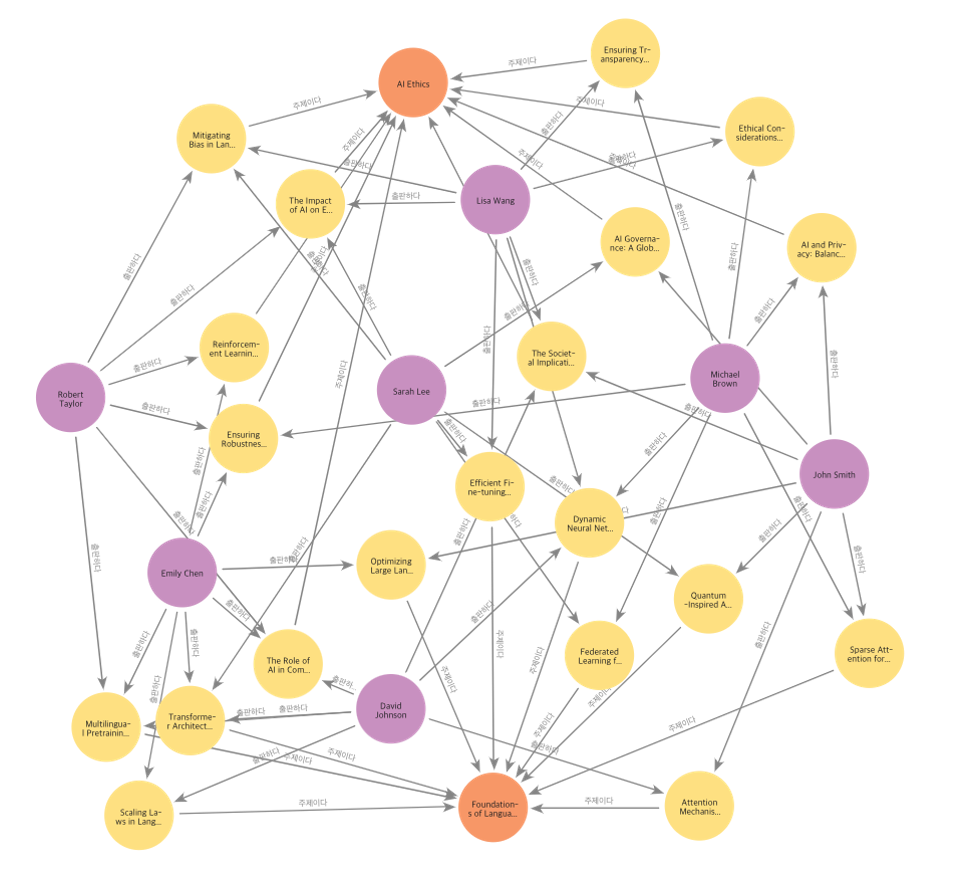

### 벡터 인덱스 구축

이제 *주제, 제목, 초록*을 기반으로 관련 *논문*을 효율적으로 검색하기 위한 벡터 인덱스를 구축합니다. 이 과정에는 이러한 필드를 사용하여 각 논문의 임베딩을 계산하는 것이 포함됩니다. 쿼리 시, 시스템은 코사인 거리와 같은 유사도 메트릭을 사용하여 사용자 입력과 가장 유사한 논문을 찾습니다.

In [6]:
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings

vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    url=os.environ['NEO4J_URI'],
    username=os.environ['NEO4J_USERNAME'],
    password=os.environ['NEO4J_PASSWORD'],
    index_name='논문',
    node_label="논문",
    text_node_properties=['주제', '제목', '초록'],
    embedding_node_property='embedding',
)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated procedure. ('db.create.setVectorProperty' has been replaced by 'db.create.setNodeVectorProperty')} {position: line: 1, column: 64, offset: 63} for query: "UNWIND $data AS row MATCH (n:`논문`) WHERE elementId(n) = row.id CALL db.create.setVectorProperty(n, 'embedding', row.embedding) YIELD node RETURN count(*)"


**참고**: OpenAI 임베딩 모델에 접근하려면 OpenAI 계정을 만들고 API 키를 받아 `OPENAI_API_KEY`를 환경 변수로 설정해야 합니다. 다른 [임베딩 모델](https://python.langchain.com/v0.2/docs/integrations/text_embedding/) 통합을 실험해 보는 것도 유용할 수 있습니다.

## 유사도 기반 Q&A

`Langchain RetrievalQA`는 위의 벡터 인덱스를 검색기로 사용하는 질문-답변(QA) 체인을 생성합니다.

In [7]:
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI

vector_qa = RetrievalQA.from_chain_type(
    llm=ChatOpenAI(),
    chain_type="stuff",
    retriever=vector_index.as_retriever()
)

'*AI가 우리의 일상 생활에 어떤 영향을 미칠 수 있는지 논의하는 논문은 어떤 것들이 있나요?*'라고 물어봅시다.

In [8]:
r = vector_qa.invoke(
    {"query": "AI가 우리의 일상 생활에 어떤 영향을 미칠 수 있는지 논의하는 논문은 어떤 것들이 있나요? 논문 제목과 초록을 포함해서 말해주세요."}
)
print(r['result'])

주제: AI의 영향

1. 제목: The Impact of AI on Employment: A Comprehensive Study
   - 초록: 이 연구는 AI가 다양한 직업 부문에 미칠 수 있는 잠재적 영향을 분석하고 부정적 영향을 완화하기 위한 정책 권고를 제안합니다.

2. 제목: The Societal Implications of Advanced AI: A Multidisciplinary Analysis
   - 초록: 우리의 연구는 다양한 분야의 전문가들을 모아 고급 AI가 사회, 경제, 문화에 미칠 잠재적인 장기적 영향을 분석합니다.

3. 제목: The Role of AI in Combating Climate Change: Opportunities and Challenges
   - 초록: 우리의 연구는 AI가 기후 변화 대처에 어떻게 활용될 수 있는지 탐구하며 잠재적 이점과 관련된 윤리적 고려사항을 논의합니다.

4. 제목: Ethical Considerations in AI Development
   - 초록: 우리는 고속으로 진행되고 있는 AI 발전의 윤리적 함의를 탐구하고 책임있는 개발을 위한 지침을 제안합니다.


## 추론을 위한 지식 그래프 탐색

지식 그래프는 엔티티 간의 연결을 만드는 데 탁월하여 패턴을 추출하고 새로운 인사이트를 발견할 수 있게 합니다.

이 섹션에서는 이 프로세스를 구현하고 자연어 쿼리를 사용하여 LLM 파이프라인에 결과를 통합하는 방법을 보여줍니다.

### LangChain을 사용한 그래프 Cypher 체인

표현력 있고 효율적인 쿼리를 구성하기 위해 `Neo4j`는 SQL에서 영감을 받은 선언적 쿼리 언어인 `Cypher`를 사용합니다. `LangChain`은 `GraphCypherQAChain` 래퍼를 제공하여 자연어를 사용해 그래프 데이터베이스를 쿼리할 수 있게 하는 추상화 계층을 제공하여 LLM 파이프라인에 그래프 기반 데이터 검색을 더 쉽게 통합할 수 있게 합니다.

실제로 `GraphCypherQAChain`은:
- 맥락 내 학습(프롬프트 엔지니어링)을 적용하여 사용자 입력(자연어)에서 Cypher 문(Neo4j와 같은 그래프 데이터베이스용 쿼리)을 생성하고,
- 해당 문을 그래프 데이터베이스에 대해 실행하며,
- LLM 응답을 정확하고 최신 정보로 뒷받침하기 위해 결과를 컨텍스트로 제공합니다.

**참고**: 이 구현에는 모델이 생성한 그래프 쿼리를 실행하는 것이 포함되어 있어, 데이터베이스의 민감한 데이터에 대한 의도하지 않은 접근이나 수정과 같은 고유한 위험이 있습니다. 이러한 위험을 완화하기 위해 데이터베이스 연결 권한을 체인/에이전트의 특정 요구 사항을 충족하는 데 필요한 최소한으로 제한해야 합니다. 이 접근 방식은 위험을 줄이지만 완전히 제거하지는 않습니다.

In [9]:
from langchain.chains import GraphCypherQAChain
from langchain_openai import ChatOpenAI

graph.refresh_schema()

cypher_chain = GraphCypherQAChain.from_llm(
    cypher_llm = ChatOpenAI(temperature=0, model_name='gpt-4o'),
    qa_llm = ChatOpenAI(temperature=0, model_name='gpt-4o'), 
    graph=graph,
    verbose=True,
)

### 자연어를 사용한 쿼리 예시

다음 예제에서 cypher 쿼리 실행 결과가 LLM에 컨텍스트로 제공되는 방식에 주목하세요.

#### **"*Emily Chen이 발표한 논문은 몇 편인가요?*"**

이 예제에서 우리의 질문 '*Emily Chen이 발표한 논문은 몇 편인가요?*'는 다음과 같은 Cypher 쿼리로 변환됩니다.

```
MATCH (:연구원 {이름: "Emily Chen"})-[:출판하다]->(n:논문)
RETURN COUNT(n) AS 논문_수
```

이 쿼리는 이름이 'Emily Chen'인 `연구원` 레이블이 있는 노드를 매칭하고 `출판하다` 관계를 통해 `논문` 노드로 이동합니다. 그런 다음 'Emily Chen'과 연결된 `논문` 노드의 수를 계산합니다.

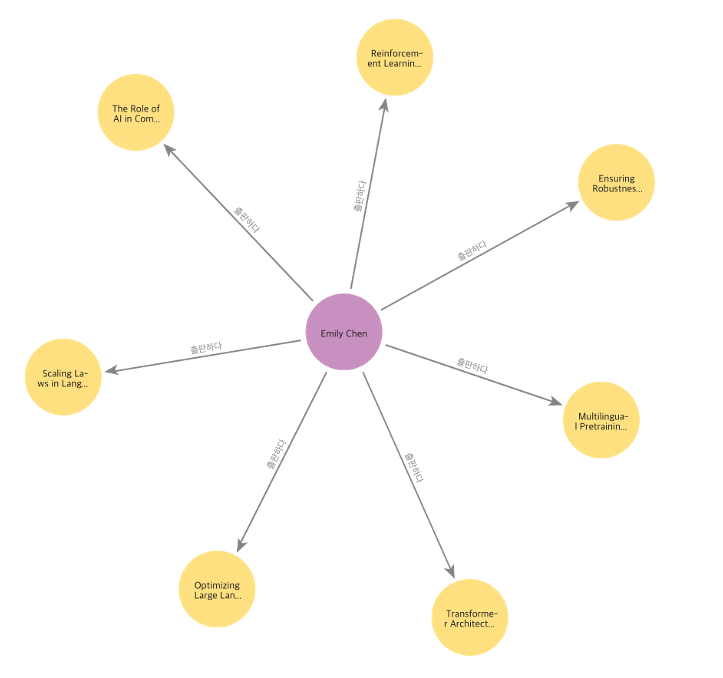

In [10]:
# 답은 '7'이어야 합니다.
cypher_chain.invoke(
    {"query": "Emily Chen이 발표한 논문은 몇 편인가요?"}
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (:연구원 {이름: "Emily Chen"})-[:출판하다]->(n:논문)
RETURN COUNT(n) AS 논문_수

Full Context:
[{'논문_수': 7}]

> Finished chain.


{'query': 'Emily Chen이 발표한 논문은 몇 편인가요?',
 'result': 'Emily Chen이 발표한 논문은 7편입니다.'}

#### **"*3편보다 많은 논문을 함께 발표한 연구원 쌍을 알려주세요.*"**

이 예제에서 '*3편보다 많은 논문을 함께 발표한 연구원 쌍을 알려주세요.*'라는 쿼리는 다음과 같은 Cypher 쿼리로 변환됩니다.


```
MATCH (r1:연구원)-[:출판하다]->(p:논문)<-[:출판하다]-(r2:연구원)
WHERE r1 <> r2
WITH r1, r2, COUNT(p) AS 논문수
WHERE 논문수 > 3
RETURN r1.이름 AS 연구원1, r2.이름 AS 연구원2, 논문수
```

이 쿼리는 `연구원` 노드에서 `출판하다` 관계를 통해 연결된 `논문` 노드를 찾고, 다시 `연구원` 쌍을 찾기 위해 역으로 이동합니다.

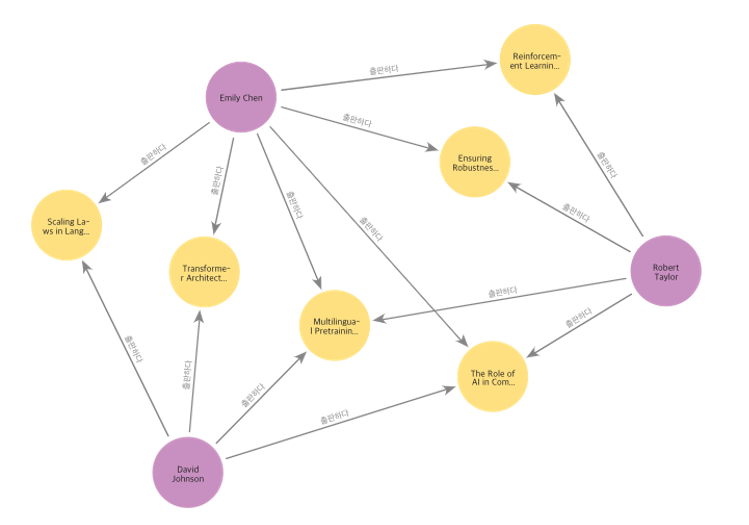

In [11]:
# 답은 David Johnson & Emily Chen, Robert Taylor & Emily Chen이어야 합니다.
cypher_chain.invoke(
    {"query": "3편보다 많은 논문을 함께 발표한 연구원 쌍을 알려주세요."}
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (r1:연구원)-[:출판하다]->(p:논문)<-[:출판하다]-(r2:연구원)
WHERE r1 <> r2
WITH r1, r2, COUNT(p) AS 논문수
WHERE 논문수 > 3
RETURN r1.이름 AS 연구원1, r2.이름 AS 연구원2, 논문수

Full Context:
[{'연구원1': 'David Johnson', '연구원2': 'Emily Chen', '논문수': 4}, {'연구원1': 'Robert Taylor', '연구원2': 'Emily Chen', '논문수': 4}, {'연구원1': 'Emily Chen', '연구원2': 'David Johnson', '논문수': 4}, {'연구원1': 'Emily Chen', '연구원2': 'Robert Taylor', '논문수': 4}]

> Finished chain.


{'query': '3편보다 많은 논문을 함께 발표한 연구원 쌍을 알려주세요.',
 'result': 'David Johnson와 Emily Chen, Robert Taylor와 Emily Chen은 3편보다 많은 논문을 함께 발표한 연구원 쌍입니다.'}

#### **"*가장 많은 동료와 협업한 연구원은 누구인가요?*"**

가장 많은 동료와 협업한 연구자를 찾아봅시다. 우리의 쿼리 '*가장 많은 동료와 협업한 연구원은 누구인가요?*'는 이제 다음과 같은 Cypher 쿼리로 변환됩니다.

```
MATCH (r:연구원)-[:출판하다]->(:논문)<-[:출판하다]-(coauthor:연구원)
WHERE r <> coauthor
RETURN r.이름 AS 연구원, COUNT(DISTINCT coauthor) AS 동료수
ORDER BY 동료수 DESC
LIMIT 1
```

여기서는 모든 `연구원` 노드에서 시작하여 그들의 `출판하다` 관계를 통해 연결된 `논문` 노드를 찾습니다. 각 `논문` 노드에 대해 Neo4j는 다시 동일한 논문을 발표한 다른 `연구원` 노드를 찾기 위해 역으로 이동합니다.

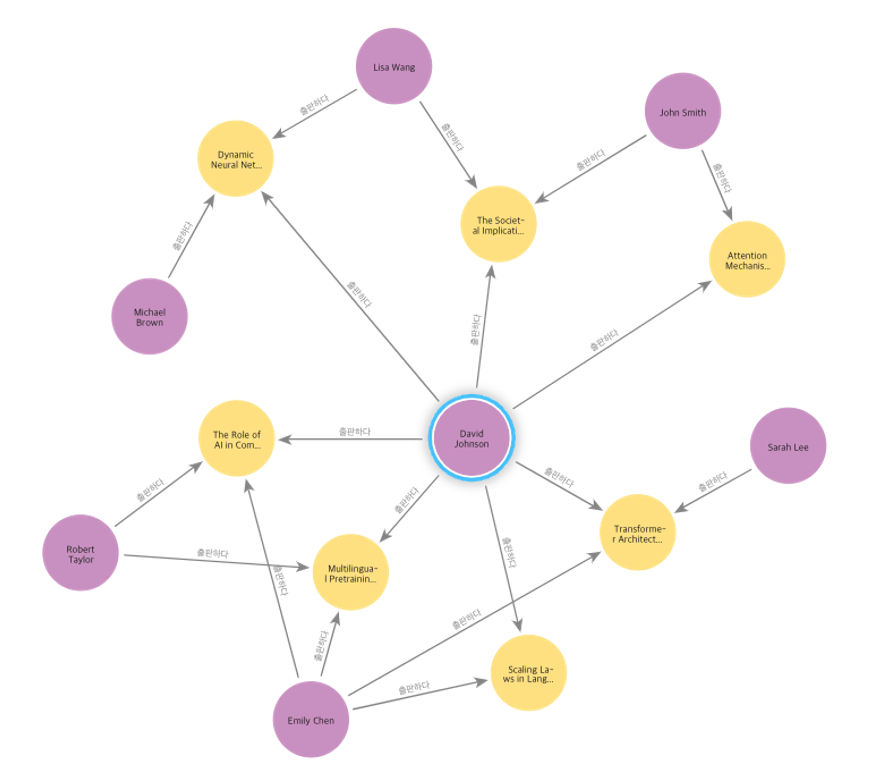

In [12]:
# 답은 'David Johnson'이어야 합니다.
cypher_chain.invoke(
    {"query": "가장 많은 동료와 협업한 연구원은 누구인가요?"}
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (r:연구원)-[:출판하다]->(:논문)<-[:출판하다]-(coauthor:연구원)
WHERE r <> coauthor
RETURN r.이름 AS 연구원, COUNT(DISTINCT coauthor) AS 동료수
ORDER BY 동료수 DESC
LIMIT 1

Full Context:
[{'연구원': 'David Johnson', '동료수': 6}]

> Finished chain.


{'query': '가장 많은 동료와 협업한 연구원은 누구인가요?',
 'result': 'David Johnson은 6명의 동료와 협업한 연구원입니다.'}

----